In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os, sys
import scipy.ndimage
import pickle
from multiprocessing import Pool
from skimage import measure, morphology
import random
import pylab
import skimage.transform

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, figure, hist, plot, scatter, colorbar
%matplotlib inline

np.random.seed(314159)
random.seed(314159)



In [5]:
#Continue here if preprocessing data from scratch
DATA_PATH = '/media/sohn/Storage/data_tcia_mammo/CBIS-DDSM/'

In [6]:
#Getting names of files in DATA_PATH
def get_file_names(path):
    x=[]
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            x.append(os.path.join(root, name))
    return x

In [7]:
#Read in the labels & file names
file_names = get_file_names(DATA_PATH)
df = pd.read_csv(DATA_PATH + '../mass_case_description_train_set.csv')
df2 = pd.read_csv(DATA_PATH + '../calc_case_description_train_set.csv')

In [8]:
#Convert file names to a dataframe for Mass-Training Set
df["file_name"] = [ None for x in range(len(df)) ]

for n in range(len(df)):
    key = '/Mass-Training_' + df["patient_id"][n] +'_'+ df["side"][n] +'_'+ df["view"][n] + '/'
    for fn in file_names:
        if key in fn:
            df.loc[n, "file_name"] = fn
            break

In [9]:
#Convert file names to a dataframe for Calcium-Training Set
df2["file_name"] = [ None for x in range(len(df2)) ]
for n in range(len(df2)):
    key = 'Calc-Training_' + df2["patient_id"][n] +'_'+ df2["side"][n] +'_'+ df2["view"][n] + '/'
    for fn in file_names:
        if key in fn:
            df2.loc[n, "file_name"] = fn
            break

In [10]:
#Experiment: Check if all filenames are accounted for. 
for n in range(len(df)):
    if  df.loc[n, "file_name"] is None:
        print(n)

In [11]:
#Drop labels/files that are not found in both label & folder name: several in Calc-Training
k=[]
for n in range(len(df2)):
    if  df2.loc[n, "file_name"] is None:
        k.append(n)
df2=df2.drop(k)
print(k)


[26, 52, 77, 130, 139, 159, 173, 175, 179, 180, 187, 199, 237, 238, 242, 248, 263, 304, 322, 324, 349, 356, 357, 432, 433, 457, 526, 529, 547, 604, 626, 687, 734, 739, 747, 751, 787, 799, 803, 810, 823, 828, 832, 873, 875, 893, 894, 921, 929, 930, 949, 984, 985, 1007, 1026, 1042, 1043, 1114, 1128, 1134, 1214, 1240, 1249, 1255, 1264, 1301, 1357, 1358, 1365, 1434, 1440, 1452, 1594]


In [12]:
#Create full file names list
file_names = list(df["file_name"]) + list(df2["file_name"])
breast_density = list(df["breast_density"]) + list(df2["breast_density"])
len(file_names)
len(breast_density)

2867

In [13]:
#Experiment
file_names[1227]

'/media/sohn/Storage/data_tcia_mammo/CBIS-DDSM/Mass-Training_P_01757_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.120155559212697412402248846631284749500/1.3.6.1.4.1.9590.100.1.2.327387078711475982721920741524139499720/000000.dcm'

In [14]:
#Exclude mass 732, 956, 1227 (ID 1057 R MLO, ID 1371 R CC, ID 1757 R CC) due to corrupt dicom
file_names = file_names[:732] + file_names[733:956] + file_names[957:1227] + file_names[1228:]
breast_density = breast_density[:732] + breast_density[733:956] + breast_density[957:1227] + breast_density[1228:]
# TODO same for density

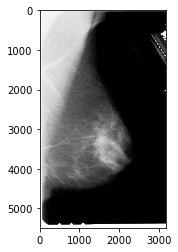

In [15]:
#Experiment
d = dicom.read_file(file_names[955]) #732 gives error
image = d.pixel_array
image_small = skimage.transform.resize(image, (224,224), preserve_range=True)
imshow(image, cmap='gray')
plt.show()

In [36]:
#WARNING Take Long Time: Create an image file of all images from file_names
images = []
for fn in file_names:
    d = dicom.read_file(fn)
    image = d.pixel_array
    image_small = skimage.transform.resize(image, (224,224), preserve_range=True) #specify image resize
    images.append(image_small)
len(images)

In [39]:
#Form X and Y numpy arrays from loaded DICOM images
X = np.stack(images)[...,None]
X = np.repeat(X, 3, axis=-1) #because ImageNet is RGB
X = (X - np.mean(X)) / np.std(X)

y = np.asarray(breast_density)-1
y = y[ :X.shape[0] ]

In [40]:
#Save loaded images to numpy files
np.save('mdata_X.npy', X)
np.save('mdata_y.npy', y)

In [116]:
#Experiment
X[1,1:3,1:5]

array([[[ 2.92396484,  2.92396484,  2.92396484],
        [ 2.11168513,  2.11168513,  2.11168513],
        [ 1.96401066,  1.96401066,  1.96401066],
        [ 1.85831236,  1.85831236,  1.85831236]],

       [[ 1.72578596,  1.72578596,  1.72578596],
        [ 1.6870422 ,  1.6870422 ,  1.6870422 ],
        [ 1.55695906,  1.55695906,  1.55695906],
        [ 1.54164098,  1.54164098,  1.54164098]]])

In [121]:
#Experiment
y[1:10]

array([2, 2, 2, 2, 2, 2, 2, 1, 1])

In [16]:
### Start Here if using previously saved DICOM images
X = np.load('mdata_X.npy')
y = np.load('mdata_y.npy')

In [17]:
#Experiment
len(X)

2864

In [18]:
#Experiment
len(y)

2864

In [19]:
#Import Keras Libraries
from keras.applications import VGG16, Xception, ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Conv2D, Dense, Flatten
from keras_tqdm import TQDMNotebookCallback
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [20]:
#Import Model from Keras

#model_base = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
model_base = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
#model_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

#model_base.summary()

In [21]:
#Add additional custom-designed top-layers
x = model_base.layers[-1].output
x = Flatten()(x)
x = Dense(512, kernel_initializer='orthogonal', activation='relu')(x)
x = Dense(4, kernel_initializer='orthogonal', activation='softmax')(x)

model2 = Model(model_base.inputs, x)
#print(model2.summary())

In [22]:
print(model2.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

In [45]:
#Specify Model Hyperparameters

#model2.compile(loss='squared_hinge', metrics=['accuracy'], optimizer=optimizer)
optimizer = Adam(lr=0.0001)
model2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [46]:
#Train the Model
model2.fit(
    X, 
    y, 
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    verbose=0, 
    callbacks=[TQDMNotebookCallback(leave_inner=True)])

In [48]:
#Save the Model
model2.save('br_vgg16_e10_lr3_bs32.h5')

In [ ]:
#Load Existing Model - Start from Here if available
model2 = model.load('br_vgg16_e10_lr3_bs32.h5')

In [129]:
shift = 0.2
train_datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=shift, height_shift_range=shift)

In [130]:
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow(X,y)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

In [49]:
#Make Predictions based on trained model
y_pred = model2.predict(X)

In [106]:
#Assign variables for error analysis.
y_pred_assigned = [ np.argmax(y_pred[n]) for n in range(len(y_pred)) ]
y_pred_conf = [ np.max(y_pred[n]) for n in range(len(y_pred)) ]

nt = -len(y)//5
Xt = X[nt:]
yt = y[nt:]
ypredt = y_pred[nt:]
yassignedt = y_pred_assigned[nt:]
yconft = y_pred_conf[nt:]

In [107]:
#Experiment: Take a look at y vs ypred assignment
list(zip(y, y_pred_assigned,y_pred_conf))[:-50]

In [56]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          do_cell_labels=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm / np.amax(cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    if do_cell_labels:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
#Confusion Matrix for Later 20% of Data
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y[-len(y)//5:], y_pred_assigned[-len(y)//5:])
cm

Confusion matrix, without normalization
[[ 42  18   2   0]
 [ 17 101  47   0]
 [  1  20 195   7]
 [  0   3  82  38]]


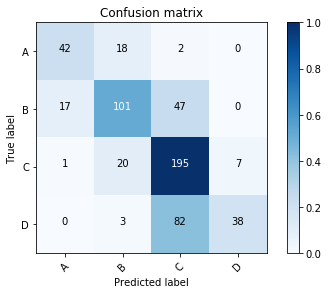

In [161]:
plot_confusion_matrix(cm, ['A', 'B', 'C', 'D'], normalize=False, do_cell_labels=True)

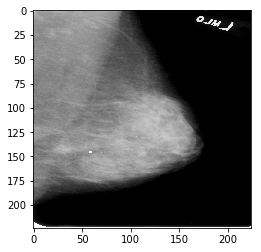

In [58]:
#Experiment
imshow(X[1,:,:,0], cmap='gray')

Radiologist: 3 ; Algorithm:  3 ( 0.987046 )


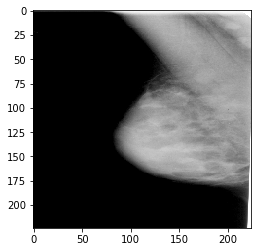

Radiologist: 3 ; Algorithm:  3 ( 0.983796 )


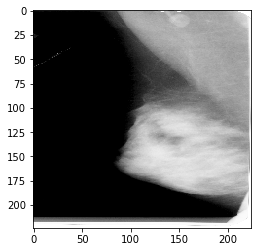

Radiologist: 3 ; Algorithm:  3 ( 0.970444 )


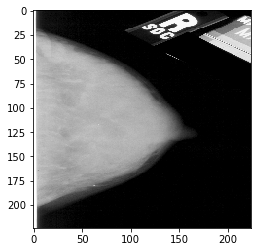

Radiologist: 3 ; Algorithm:  3 ( 0.962215 )


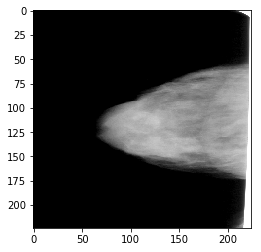

In [156]:
# Most confident, Correct, Density B
idxs = np.argsort(ypredt[:,1])[::-1]
for n in range(4):
    idx = idxs[n]
    if yt[idx] == 1:
        print("Radiologist:", yt[idx], "; Algorithm: ", yassignedt[idx], "(", yconft[idx], ")")
        imshow(Xt[idx,:,:,0], cmap='gray')
        plt.show()

Radiologist: 2 ; Algorithm:  3 ( 0.920101 )


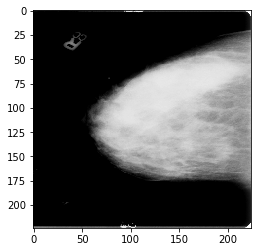

Radiologist: 2 ; Algorithm:  3 ( 0.768053 )


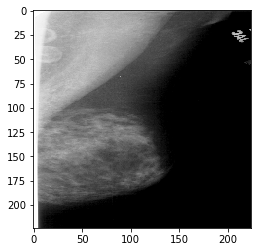

Radiologist: 2 ; Algorithm:  3 ( 0.754755 )


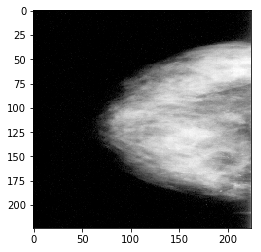

Radiologist: 2 ; Algorithm:  3 ( 0.647548 )


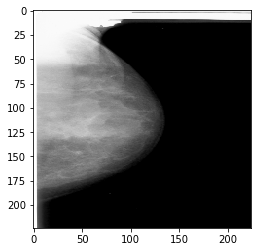

Radiologist: 2 ; Algorithm:  3 ( 0.59779 )


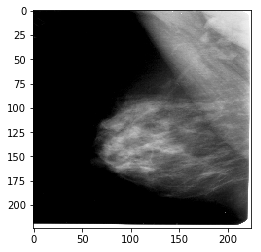

Radiologist: 2 ; Algorithm:  3 ( 0.578753 )


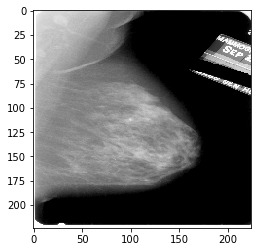

Radiologist: 2 ; Algorithm:  3 ( 0.55799 )


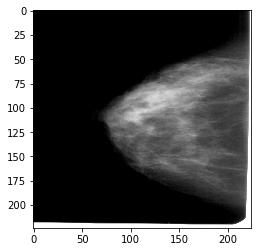

In [159]:
# Most confident, Incorrect, Density B
idxs = np.argsort(ypredt[:,3])[::-1]
for n in range(45):
    idx = idxs[n]
    if yt[idx] != 3:
        print("Radiologist:", yt[idx], "; Algorithm: ", yassignedt[idx], "(", yconft[idx], ")")
        imshow(Xt[idx,:,:,0], cmap='gray')
        plt.show()

Radiologist: 0 ; Algorithm:  0 ( 0.957513 )


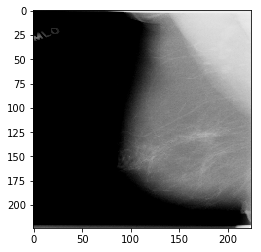

Radiologist: 2 ; Algorithm:  1 ( 0.563699 )


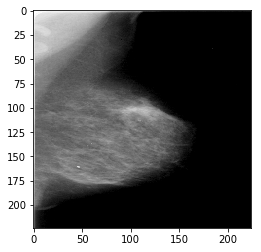

Radiologist: 2 ; Algorithm:  1 ( 0.510934 )


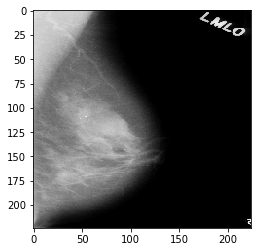

Radiologist: 1 ; Algorithm:  1 ( 0.533261 )


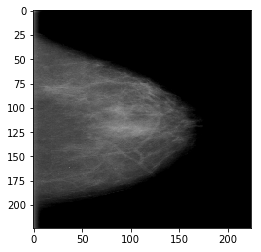

Radiologist: 3 ; Algorithm:  3 ( 0.904358 )


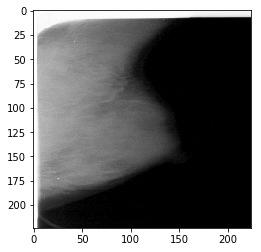

Radiologist: 3 ; Algorithm:  2 ( 0.978788 )


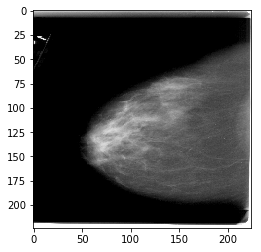

Radiologist: 2 ; Algorithm:  2 ( 0.954692 )


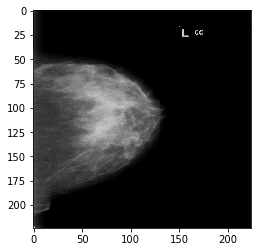

Radiologist: 0 ; Algorithm:  1 ( 0.621878 )


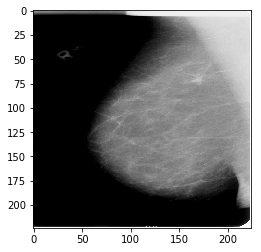

Radiologist: 1 ; Algorithm:  1 ( 0.866565 )


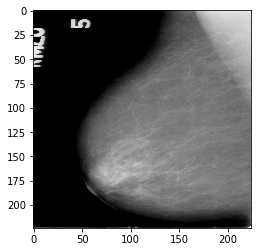

Radiologist: 3 ; Algorithm:  2 ( 0.535563 )


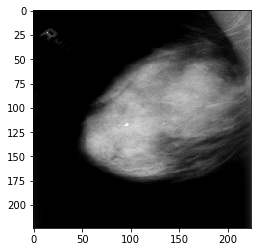

In [160]:
# Random 10
idxs = np.random.permutation(len(yt))
for n in range(10):
    idx = idxs[n]
    print("Radiologist:", yt[idx], "; Algorithm: ", yassignedt[idx], "(", yconft[idx], ")")
    imshow(Xt[idx,:,:,0], cmap='gray')
    plt.show()

Radiologist: 2 ; Algorithm:  2 ( 0.995288 )


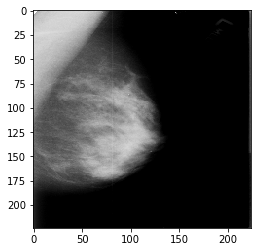

Radiologist: 2 ; Algorithm:  2 ( 0.992809 )


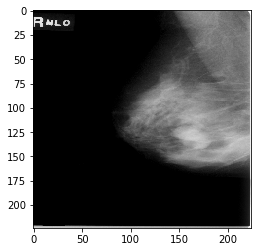

Radiologist: 2 ; Algorithm:  2 ( 0.992462 )


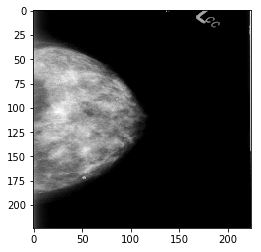

In [142]:
# Most confident, Correct, Density C
idxs = np.argsort(ypredt[:,2])[::-1]
for n in range(10):
    idx = idxs[n]
    if yt[idx] == 2:
        print("Radiologist:", yt[idx], "; Algorithm: ", yassignedt[idx], "(", yconft[idx], ")")
        imshow(Xt[idx,:,:,0], cmap='gray')
        plt.show()

Radiologist: 3 ; Algorithm:  2 ( 0.995008 )


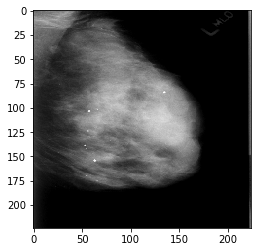

Radiologist: 3 ; Algorithm:  2 ( 0.995008 )


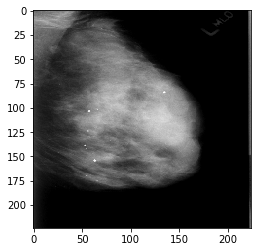

Radiologist: 3 ; Algorithm:  2 ( 0.995008 )


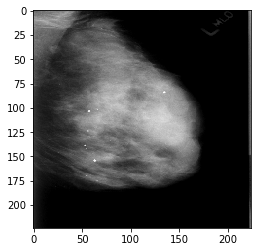

Radiologist: 3 ; Algorithm:  2 ( 0.995008 )


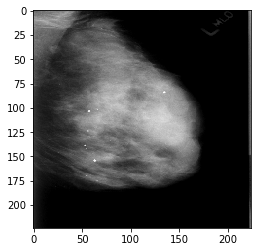

Radiologist: 3 ; Algorithm:  2 ( 0.995008 )


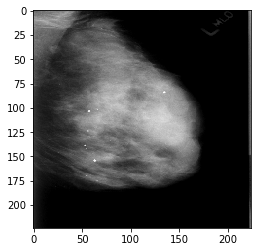

Radiologist: 3 ; Algorithm:  2 ( 0.995008 )


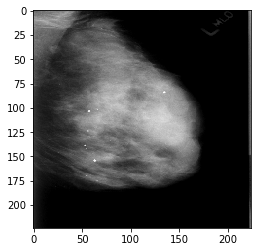

Radiologist: 3 ; Algorithm:  2 ( 0.992505 )


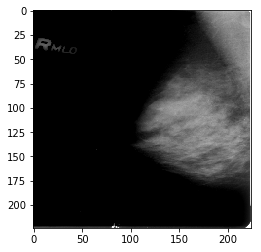

Radiologist: 3 ; Algorithm:  2 ( 0.988521 )


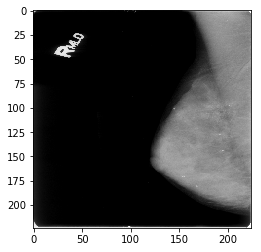

Radiologist: 3 ; Algorithm:  2 ( 0.987739 )


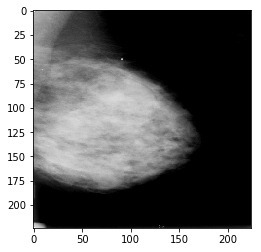

Radiologist: 3 ; Algorithm:  2 ( 0.986529 )


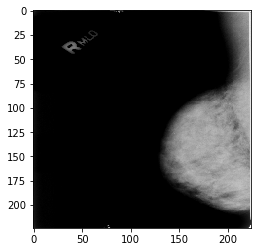

Radiologist: 3 ; Algorithm:  2 ( 0.978788 )


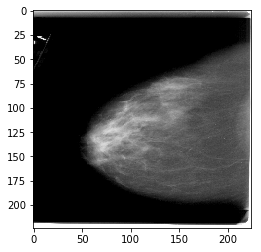

In [151]:
# Most confident, Incorrect, Density C
idxs = np.argsort(ypredt[:,2])[::-1]
for n in range(50):
    idx = idxs[n]
    if yt[idx] != 2:
        print("Radiologist:", yt[idx], "; Algorithm: ", yassignedt[idx], "(", yconft[idx], ")")
        imshow(Xt[idx,:,:,0], cmap='gray')
        plt.show()

Radiologist: 2 ; Algorithm:  3 ( 0.920101 )


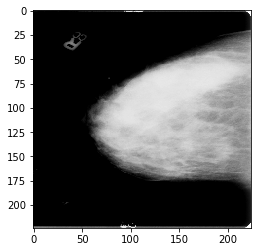

Radiologist: 2 ; Algorithm:  3 ( 0.768053 )


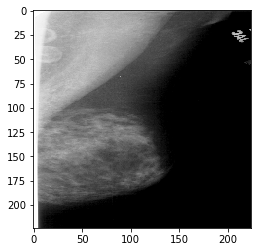

Radiologist: 2 ; Algorithm:  3 ( 0.754755 )


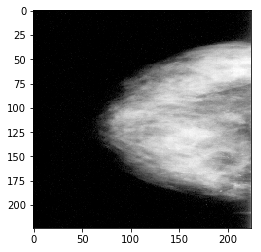

Radiologist: 2 ; Algorithm:  3 ( 0.647548 )


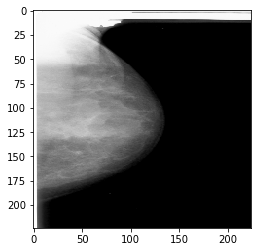

Radiologist: 2 ; Algorithm:  3 ( 0.59779 )


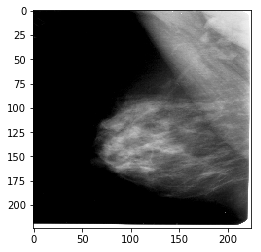

Radiologist: 2 ; Algorithm:  3 ( 0.578753 )


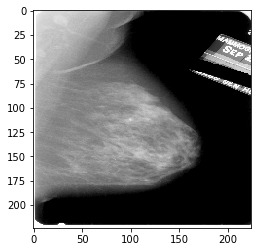

Radiologist: 2 ; Algorithm:  3 ( 0.55799 )


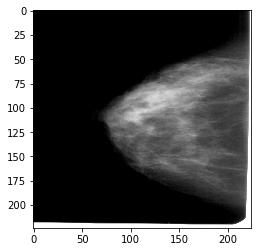

Radiologist: 3 ; Algorithm:  2 ( 0.532525 )


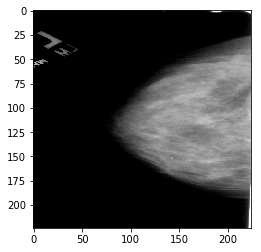

Radiologist: 3 ; Algorithm:  2 ( 0.535563 )


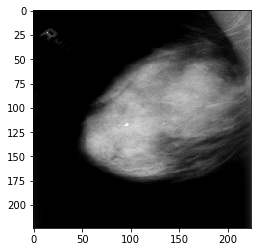

Radiologist: 3 ; Algorithm:  2 ( 0.535563 )


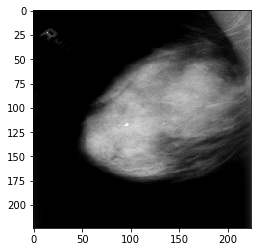

Radiologist: 3 ; Algorithm:  2 ( 0.535563 )


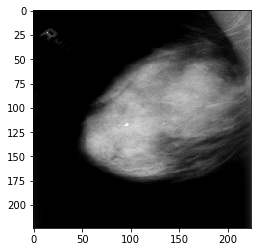

Radiologist: 3 ; Algorithm:  2 ( 0.535563 )


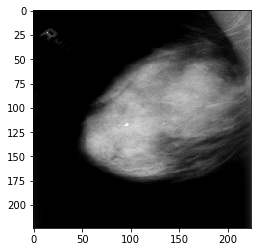

In [149]:
# Most confident, Incorrect, Density D
idxs = np.argsort(ypredt[:,3])[::-1]
for n in range(50):
    idx = idxs[n]
    if yt[idx] != int(yassignedt[idx]):
        print("Radiologist:", yt[idx], "; Algorithm: ", yassignedt[idx], "(", yconft[idx], ")")
        imshow(Xt[idx,:,:,0], cmap='gray')
        plt.show()

100 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00119_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.84373335711265981107072429013852700683/1.3.6.1.4.1.9590.100.1.2.162472214911834322918274730690308343211/000000.dcm


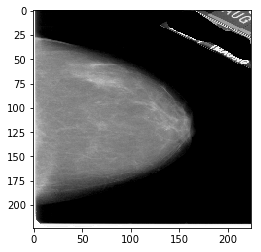

101 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00119_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.30504514511852775512570576910317108404/1.3.6.1.4.1.9590.100.1.2.170111429811771449622378492430819679130/000000.dcm


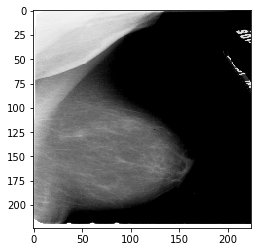

102 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00120_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.394913019612359833430911610221650604470/1.3.6.1.4.1.9590.100.1.2.23478273011012398821262698602156931512/000000.dcm


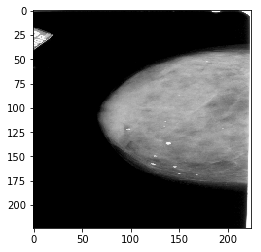

103 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00120_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.184778625211858710825872078080323501795/1.3.6.1.4.1.9590.100.1.2.70012532911736490135306300510795887564/000000.dcm


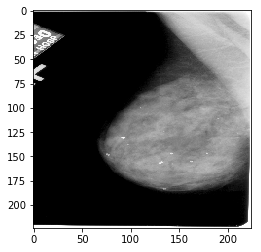

104 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00122_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.23102643111095874815641619593788162692/1.3.6.1.4.1.9590.100.1.2.362722981912364196037055929741492450134/000000.dcm


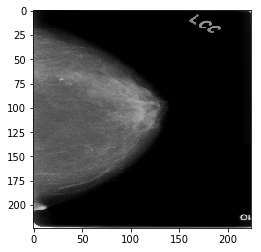

105 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00128_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.236255504711983139029827969633730051330/1.3.6.1.4.1.9590.100.1.2.277118485712837089912775450911866183239/000000.dcm


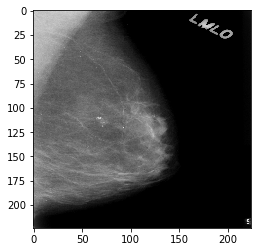

106 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00133_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.84276837810582303013177619822906083748/1.3.6.1.4.1.9590.100.1.2.265137984313406655725419002090356526005/000000.dcm


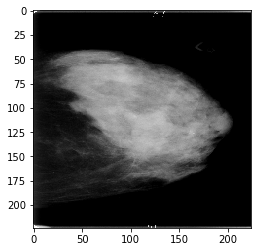

107 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00133_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.373838233811843295909087976113347550682/1.3.6.1.4.1.9590.100.1.2.235945521811290740616561100123700737471/000000.dcm


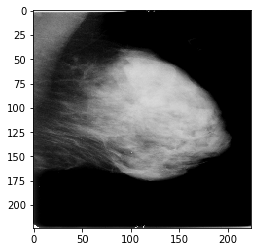

108 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00134_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.144443485411482950132661848601587611663/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/000000.dcm


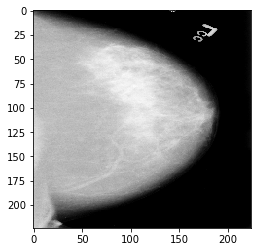

109 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00134_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.234049664813292496614584158011724449925/1.3.6.1.4.1.9590.100.1.2.289743929613127103521749541211475878547/000000.dcm


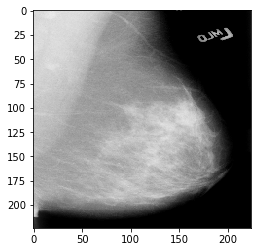

110 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00137_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.58399005513714703908223683961828996507/1.3.6.1.4.1.9590.100.1.2.291492835513257212815754341470883582190/000000.dcm


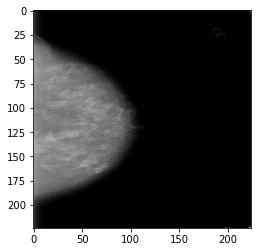

111 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00137_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.245959692011280230704435920774070167458/1.3.6.1.4.1.9590.100.1.2.223355501110410477409262071651794035858/000000.dcm


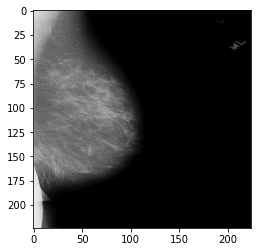

112 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00146_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.39333255511923715429976803171598161365/1.3.6.1.4.1.9590.100.1.2.221813109312502505440274540962266107790/000000.dcm


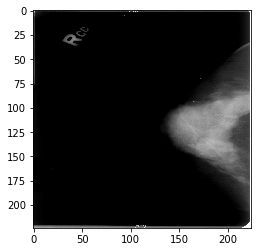

113 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00146_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.102009993011645921035139680333935890212/1.3.6.1.4.1.9590.100.1.2.138854373111438727811729486684128233341/000000.dcm


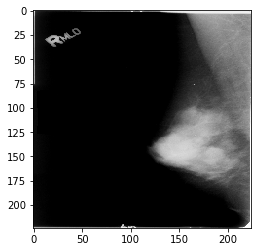

114 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00148_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.182260888511098053137818758700915932202/1.3.6.1.4.1.9590.100.1.2.397573561111296192309543223482986197152/000000.dcm


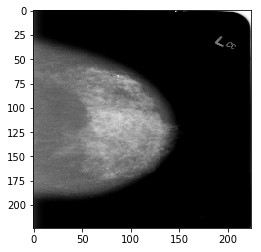

115 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00148_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.315941529012218332617921632032296630057/1.3.6.1.4.1.9590.100.1.2.218912511112733612941904682861747892974/000000.dcm


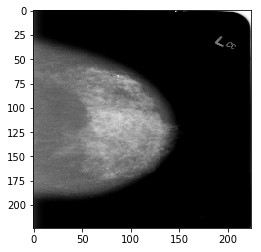

116 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00149_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.236012582411672128004632667372249941615/1.3.6.1.4.1.9590.100.1.2.63200910512557522821086711330263634348/000000.dcm


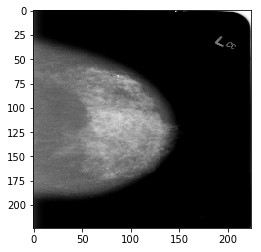

117 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00149_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.190660686611663255315580607251746347959/1.3.6.1.4.1.9590.100.1.2.78109951511092761713429881620095372440/000000.dcm


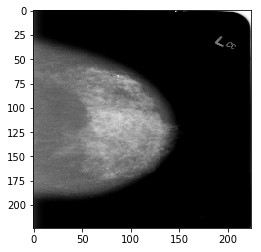

118 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00160_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.258547282711687516628026571643041139938/1.3.6.1.4.1.9590.100.1.2.192830829713156688526768249872322016275/000000.dcm


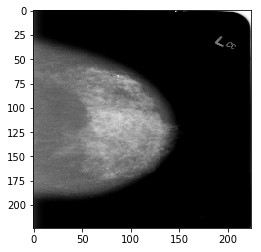

119 /media/sohn/Storage/mdata/CBIS-DDSM/Mass-Training_P_00160_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.356276030911121827918342002063263151066/1.3.6.1.4.1.9590.100.1.2.305474508013164328209392882041994773722/000000.dcm


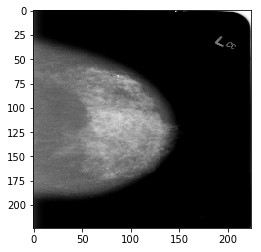

In [70]:
for n in range(100,120):
    idx = n
    print(idx, file_names[n])
    imshow(Xt[idx,:,:,0], cmap='gray')
    plt.show()